<a href="https://colab.research.google.com/github/rafaborneo/kaggle-competition/blob/main/RAFAEL_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df = pd.read_csv("travel_insurance_prediction_train.csv")

Let's take a first look on the data:

In [ ]:
df.head()

,Customer,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,1,33,Private Sector/Self Employed,Yes,550000,6,0,No,No,1
1,2,28,Private Sector/Self Employed,Yes,800000,7,0,Yes,No,0
2,3,31,Private Sector/Self Employed,Yes,1250000,4,0,No,No,0
3,4,31,Government Sector,No,300000,7,0,No,No,0
4,5,28,Private Sector/Self Employed,Yes,1250000,3,0,No,No,0


# EDA

In [ ]:
df.isnull().sum()

Customer               0
Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

Ok, no missing values.

In [ ]:
df.TravelInsurance.value_counts()

0    958
1    532
Name: TravelInsurance, dtype: int64

The dataset is imbalanced. Better to do some oversampling later.

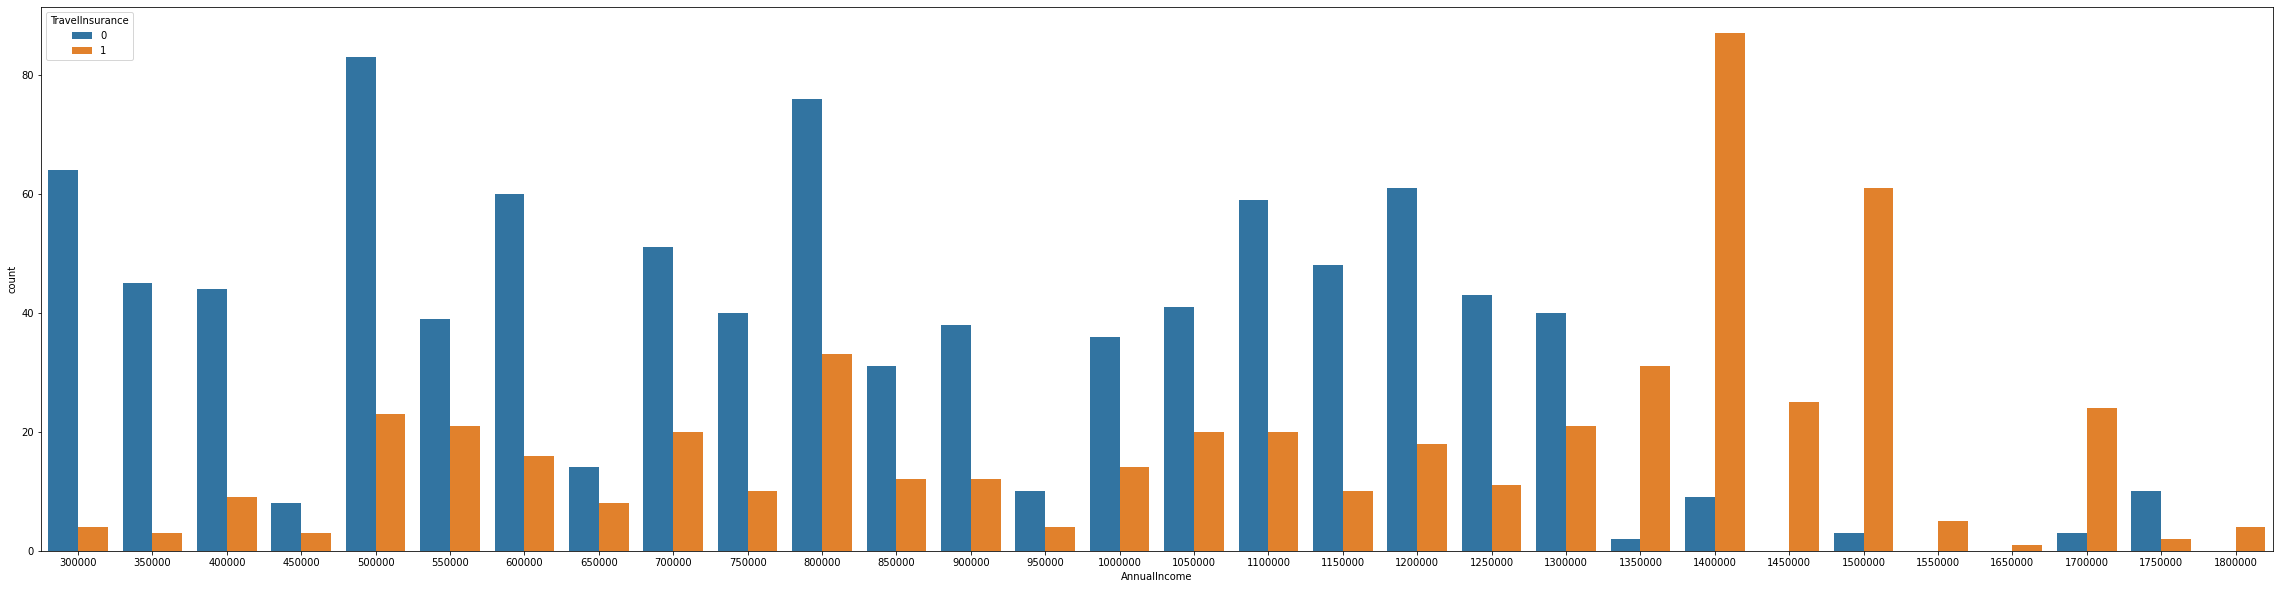

In [ ]:
plt.figure(figsize=(40,10))
sns.countplot('AnnualIncome',hue='TravelInsurance',data=df)
plt.show()

mas income mas tendencia a comprar sobre todo por encima de 1350000.

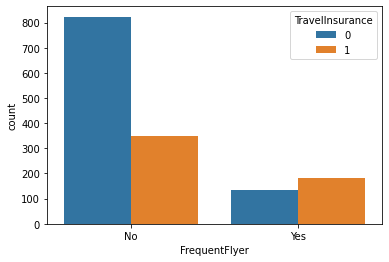

In [ ]:
sns.countplot('FrequentFlyer',hue='TravelInsurance',data=df)
plt.show()

Frequent flyers are more likely to take travel insurance.

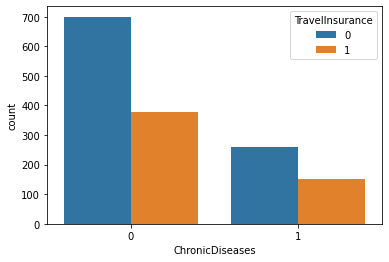

In [ ]:
sns.countplot('ChronicDiseases',hue='TravelInsurance',data=df)
plt.show()

"ChronicDiseases" doesnt seem to have much inpact on the target.

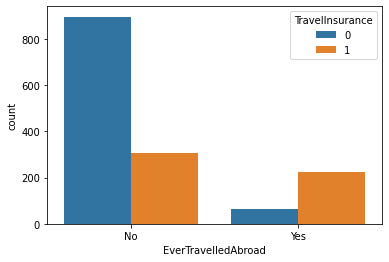

In [ ]:
sns.countplot('EverTravelledAbroad',hue='TravelInsurance',data=df)
plt.show()

People who has travelled abroad are more likely to take travel insurance.

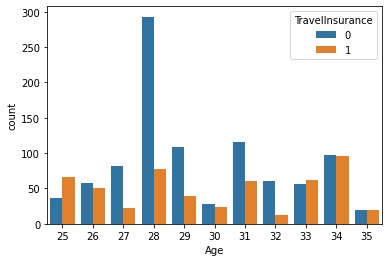

In [ ]:
sns.countplot('Age',hue='TravelInsurance',data=df)
plt.show()

People older that 33 usually take travel insurance. Take that for feature engineering.

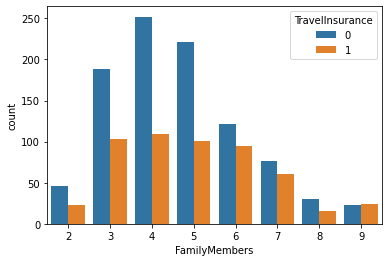

In [ ]:
sns.countplot('FamilyMembers',hue='TravelInsurance',data=df)
plt.show()

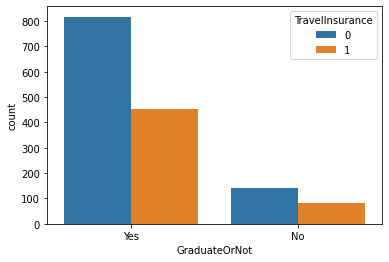

In [ ]:
sns.countplot('GraduateOrNot',hue='TravelInsurance',data=df)
plt.show()

# Feature engineering

We will use np.select to create categorical features.

In [ ]:
# Creating a numpy array of Age values 
x = df['Age'].values
# List of new categories
cat = [0, 1]
# New column based on certain conditions
df['AgeCategory']=np.select([x<=32, x>32],cat)

In [ ]:
x = df['AnnualIncome'].values
cat = [0, 1]
df['AnnualCategory']=np.select([x<=1300000, x>1300000],cat)

Replace words with 0/1 categories.

In [ ]:
df['Employment Type'].replace({'Private Sector/Self Employed':0, 'Government Sector':1},inplace=True)
df['GraduateOrNot'].replace({'No':0, 'Yes':1},inplace=True)
df['FrequentFlyer'].replace({'No':0, 'Yes':1},inplace=True)
df['EverTravelledAbroad'].replace({'No':0, 'Yes':1},inplace=True)

We no more in need of those columns:

In [ ]:
df_use = df.drop(columns=["AnnualIncome", "Age"])

In [ ]:
df_use.head()

,Customer,Employment Type,GraduateOrNot,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,AgeCategory,AnnualCategory
0,1,0,1,6,0,0,0,1,1,0
1,2,0,1,7,0,1,0,0,0,0
2,3,0,1,4,0,0,0,0,0,0
3,4,1,0,7,0,0,0,0,0,0
4,5,0,1,3,0,0,0,0,0,0


# Data preprocessing

In [ ]:
X = df_use.drop(columns=["TravelInsurance"])
y = df_use.TravelInsurance

Let's do oversampling to create a balanced dataset.

In [ ]:
X_imbalanced = np.vstack((X[y == 1], X[y == 0][:30]))
y_imbalanced = np.hstack((y[y == 1], y[y == 0][:30]))

In [ ]:
from sklearn.utils import resample

# Create oversampled training data set for minority class
X_oversampled, y_oversampled = resample(X_imbalanced[y_imbalanced == 0],
                                        y_imbalanced[y_imbalanced == 0],
                                        replace=True,
                                        n_samples=X_imbalanced[y_imbalanced == 1].shape[0],
                                        random_state=123)

# Append the oversampled minority class to training data and related labels
X_balanced = np.vstack((X[y == 1], X_oversampled))
y_balanced = np.hstack((y[y == 1], y_oversampled))

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_imbalanced, y_imbalanced, test_size=0.3, random_state=42)

# Model learning

In [ ]:
from xgboost import XGBClassifier
parameters = {'alpha': (0.1, 10), 'max_depth': (5, 10), 'learning_rate': (0.1, 1)}
clf = GridSearchCV(XGBClassifier(), parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': (0.1, 10), 'learning_rate': (0.1, 1),
                         'max_depth': (5, 10)},
             pre_dispatch='2*n_jobs', refit=True, retu

In [ ]:
from xgboost import XGBClassifier
parameters = {'alpha': (0.1, 10), 'max_depth': (5, 10), 'learning_rate': (0.1, 1)}
clfNB = GridSearchCV(XGBClassifier(), parameters)
clfNB.fit(X_train1, y_train1)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': (0.1, 10), 'learning_rate': (0.1, 1),
                         'max_depth': (5, 10)},
             pre_dispatch='2*n_jobs', refit=True, retu

In [ ]:
clf.best_params_


{'alpha': 0.1, 'learning_rate': 1, 'max_depth': 5}

In [ ]:
clfNB.best_params_

{'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 5}

In [ ]:
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       152
           1       1.00      0.98      0.99       168

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320



In [ ]:
print(classification_report(y_test1, xgb.predict(X_test1)))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.99      0.99       156

    accuracy                           0.99       169
   macro avg       0.93      0.99      0.96       169
weighted avg       0.99      0.99      0.99       169



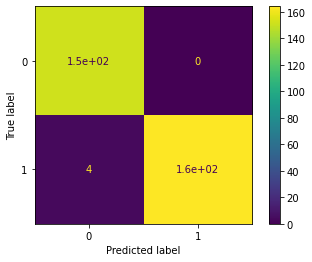

In [ ]:
plot_confusion_matrix(xgb, X_test, y_test)  
plt.show() 

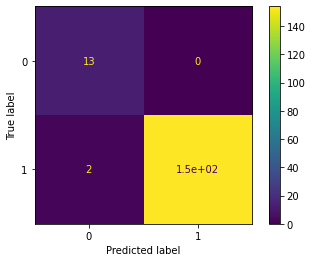

In [ ]:
plot_confusion_matrix(xgb, X_test1, y_test1)  
plt.show()